In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


https://www.kaggle.com/lepeshkinvyacheslav/8-vgg16

In [3]:
import zipfile

Разорхивируем архив с тестовыми картинками

In [4]:
zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r').extractall()

In [5]:
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense,GlobalMaxPooling2D,Dropout
from keras.models import Model
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import optimizers
%matplotlib inline 

Посмотрим первую картинку.

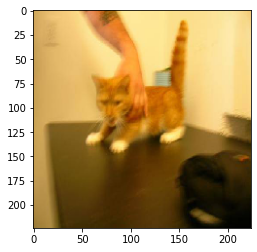

In [6]:
img_path = 'train/cat.0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

Сформируем датафрейм с метками классов и названиями файлов 1 - собака, 0 - кот.

In [7]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append("1")
    else:
        categories.append("0")

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,dog.11497.jpg,1
1,cat.528.jpg,0
2,cat.6129.jpg,0
3,dog.6744.jpg,1
4,dog.6828.jpg,1


Разделим датафрейм на тренировочный и для тестирования.

In [8]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

Создадим тренировочный и тестовый генераторы с помощью image.ImageDataGenerator

In [9]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=16
)

Found 22500 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=16
)

Found 2500 validated image filenames belonging to 2 classes.


Загрузим нейросеть VGG16.

In [11]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [12]:
last_layer = vgg.get_layer('block5_pool')
last_output = last_layer.output

Настроим модель.
Сглаживаем выходной слой до 1.
Добавим полностью связанный слой с 512 скрытыми блоками и функцией активации relu.
Добавим коэффициент отсева 0,5.
Добавим последний сигмовидный слой для классификации.


In [13]:
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [14]:
model = Model(vgg.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Проверим, чтобы последний слой обучал а не замораживал.

In [15]:
for l, layer in enumerate(model.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model.layers[-1:]):
    layer.trainable = True

Обучаем модель.

In [16]:
model.fit(train_generator,validation_data=validation_generator, epochs=4,validation_steps=total_validate//16,
    steps_per_epoch=total_train//16)

Epoch 1/4
1406/1406 [==============================] - 2818s 2s/step - loss: 0.3462 - accuracy: 0.8235 - val_loss: 0.0696 - val_accuracy: 0.9692
Epoch 2/4
1406/1406 [==============================] - 2802s 2s/step - loss: 0.0809 - accuracy: 0.9673 - val_loss: 0.0516 - val_accuracy: 0.9772
Epoch 3/4
1406/1406 [==============================] - 2802s 2s/step - loss: 0.0613 - accuracy: 0.9747 - val_loss: 0.0425 - val_accuracy: 0.9844
Epoch 4/4
1406/1406 [==============================] - 2802s 2s/step - loss: 0.0556 - accuracy: 0.9779 - val_loss: 0.0353 - val_accuracy: 0.9856


Разархивируем архив с тестовым набором изображений. 

In [17]:
zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r').extractall()

Сформируем датафрейм с именами тестовых картинок.

In [18]:
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

Создадим генератор для тестового набора данных.

In [21]:
test_gen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=16,
    target_size=(224, 224),
    shuffle=False
)

Found 12500 validated image filenames.


Делаем предсказания для тестовых картинок.

In [24]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/16))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Посмотрим некоторые результаты предсказаний.

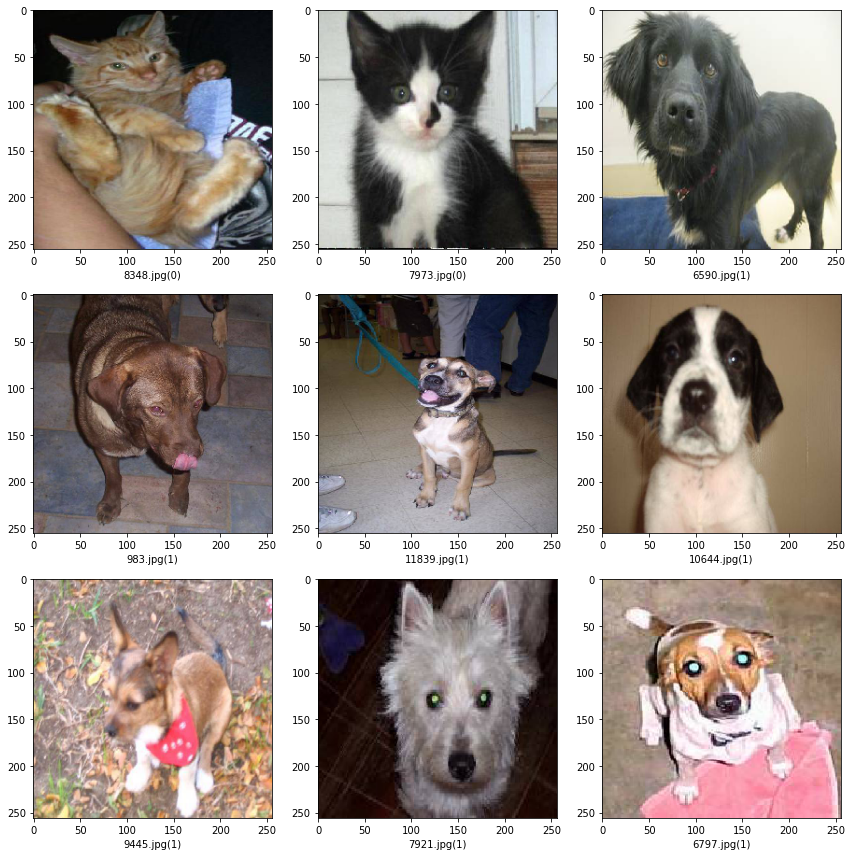

In [26]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = image.load_img("./test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

Точность обученной модели очень большая. И ей удалось правильно определить картинки выше.